## 导入所需库

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
import math
from sklearn.metrics import mean_squared_error
import talib as ta

## 读入数据

In [2]:
# read the data
dataset = pd.read_csv('20_year_FD.csv')
dataset.head()

,ts_code,trade_date,pre_close,open,high,low,close,change,pct_chg,vol,amount,label
0,510050.SH,20050223,0.887,0.881,0.882,0.866,0.876,-0.011,-1.2401,12697425.42,1111793.167,False
1,510050.SH,20050224,0.876,0.876,0.876,0.868,0.876,0.000,0.0000,4516142.23,394141.216,True
2,510050.SH,20050225,0.876,0.877,0.887,0.875,0.880,0.004,0.4566,5064606.95,446597.972,True
3,510050.SH,20050228,0.880,0.878,0.879,0.870,0.872,-0.008,-0.9091,1879651.93,164467.462,False
4,510050.SH,20050301,0.872,0.870,0.873,0.865,0.867,-0.005,-0.5734,2080944.56,180573.596,False


## 重叠类指标导入

In [3]:
def add_MA(timeperiod,df):
    types=['SMA','EMA','WMA','DEMA','TEMA',
    'TRIMA','KAMA','MAMA','T3']
    types = [i+'_'+str(timeperiod) for i in types]
    for i in range(len(types)):
        df[types[i]]=ta.MA(df.close.to_numpy(),timeperiod=timeperiod,matype=i)
    return df

In [4]:
dataset = add_MA(5,dataset)
dataset = add_MA(10,dataset)
dataset = add_MA(30,dataset)
dataset.head()

,ts_code,trade_date,pre_close,open,high,low,close,change,pct_chg,vol,...,T3_10,SMA_30,EMA_30,WMA_30,DEMA_30,TEMA_30,TRIMA_30,KAMA_30,MAMA_30,T3_30
0,510050.SH,20050223,0.887,0.881,0.882,0.866,0.876,-0.011,-1.2401,12697425.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,510050.SH,20050224,0.876,0.876,0.876,0.868,0.876,0.000,0.0000,4516142.23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,510050.SH,20050225,0.876,0.877,0.887,0.875,0.880,0.004,0.4566,5064606.95,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,510050.SH,20050228,0.880,0.878,0.879,0.870,0.872,-0.008,-0.9091,1879651.93,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,510050.SH,20050301,0.872,0.870,0.873,0.865,0.867,-0.005,-0.5734,2080944.56,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

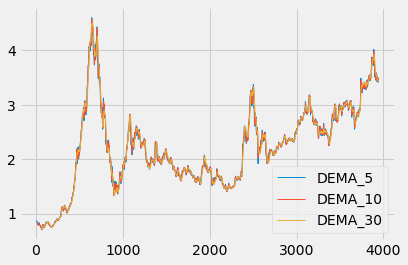

In [5]:
dataset[["DEMA_5","DEMA_10","DEMA_30"]].plot(linewidth=1)

In [6]:
#布林带计算
H_line,M_line,L_line=ta.BBANDS(dataset.close.to_numpy(), timeperiod=10, nbdevup=2, nbdevdn=2, matype=0)
dataset['H_line']=H_line
dataset['M_line']=M_line
dataset['L_line']=L_line
dataset

,ts_code,trade_date,pre_close,open,high,low,close,change,pct_chg,vol,...,WMA_30,DEMA_30,TEMA_30,TRIMA_30,KAMA_30,MAMA_30,T3_30,H_line,M_line,L_line
0,510050.SH,20050223,0.887,0.881,0.882,0.866,0.876,-0.011,-1.2401,12697425.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,510050.SH,20050224,0.876,0.876,0.876,0.868,0.876,0.000,0.0000,4516142.23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,510050.SH,20050225,0.876,0.877,0.887,0.875,0.880,0.004,0.4566,5064606.95,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,510050.SH,20050228,0.880,0.878,0.879,0.870,0.872,-0.008,-0.9091,1879651.93,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,510050.SH,20050301,0.872,0.870,0.873,0.865,0.867,-0.005,-0.5734,2080944.56,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3937,510050.SH,20210429,3.467,3.476,3.515,3.463,3.513,0.046,1.3268,5186873.94,...,3.493484,3.456002,3.446396,3.506767,3.590380,3.470301,3.538123,3.531396,3.4823,3.433204
3938,510050.SH,20210430,3.513,3.510,3.517,3.460,3.482,-0.031,-0.8824,7126829.01,...,3.492084,3.455327,3.448061,3.503054,3.588387,3.470886,3.530216,3.524318,3.4871,3.449882
3939,510050.SH,20210506,3.482,3.462,3.508,3.432,3.444,-0.038,-1.0913,6658387.28,...,3.488467,3.450101,3.442911,3.499596,3.586923,3.457443,3.522664,3.525502,3.4815,3.437498
3940,510050.SH,20210507,3.444,3.455,3.460,3.390,3.399,-0.045,-1.3066,4522384.41,...,3.482058,3.439884,3.430520,3.496042,3.582752,3.454521,3.515380,3.537535,3.4722,3.406865


<AxesSubplot:>

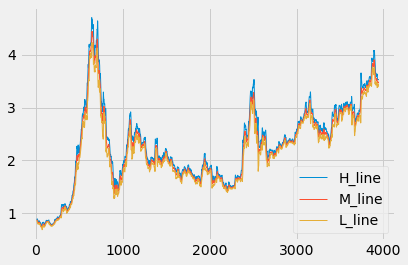

In [7]:
dataset[['H_line','M_line','L_line']].plot(linewidth=1)

In [8]:
#希尔伯特瞬时变换
dataset['ht_trendline'] = ta.HT_TRENDLINE(dataset.close.to_numpy())
dataset

,ts_code,trade_date,pre_close,open,high,low,close,change,pct_chg,vol,...,DEMA_30,TEMA_30,TRIMA_30,KAMA_30,MAMA_30,T3_30,H_line,M_line,L_line,ht_trendline
0,510050.SH,20050223,0.887,0.881,0.882,0.866,0.876,-0.011,-1.2401,12697425.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,510050.SH,20050224,0.876,0.876,0.876,0.868,0.876,0.000,0.0000,4516142.23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,510050.SH,20050225,0.876,0.877,0.887,0.875,0.880,0.004,0.4566,5064606.95,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,510050.SH,20050228,0.880,0.878,0.879,0.870,0.872,-0.008,-0.9091,1879651.93,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,510050.SH,20050301,0.872,0.870,0.873,0.865,0.867,-0.005,-0.5734,2080944.56,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3937,510050.SH,20210429,3.467,3.476,3.515,3.463,3.513,0.046,1.3268,5186873.94,...,3.456002,3.446396,3.506767,3.590380,3.470301,3.538123,3.531396,3.4823,3.433204,3.478847
3938,510050.SH,20210430,3.513,3.510,3.517,3.460,3.482,-0.031,-0.8824,7126829.01,...,3.455327,3.448061,3.503054,3.588387,3.470886,3.530216,3.524318,3.4871,3.449882,3.475560
3939,510050.SH,20210506,3.482,3.462,3.508,3.432,3.444,-0.038,-1.0913,6658387.28,...,3.450101,3.442911,3.499596,3.586923,3.457443,3.522664,3.525502,3.4815,3.437498,3.473340
3940,510050.SH,20210507,3.444,3.455,3.460,3.390,3.399,-0.045,-1.3066,4522384.41,...,3.439884,3.430520,3.496042,3.582752,3.454521,3.515380,3.537535,3.4722,3.406865,3.470880


In [9]:
dataset['midpoint'] = ta.MIDPOINT(dataset.close.to_numpy(), timeperiod=14)
dataset

,ts_code,trade_date,pre_close,open,high,low,close,change,pct_chg,vol,...,TEMA_30,TRIMA_30,KAMA_30,MAMA_30,T3_30,H_line,M_line,L_line,ht_trendline,midpoint
0,510050.SH,20050223,0.887,0.881,0.882,0.866,0.876,-0.011,-1.2401,12697425.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,510050.SH,20050224,0.876,0.876,0.876,0.868,0.876,0.000,0.0000,4516142.23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,510050.SH,20050225,0.876,0.877,0.887,0.875,0.880,0.004,0.4566,5064606.95,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,510050.SH,20050228,0.880,0.878,0.879,0.870,0.872,-0.008,-0.9091,1879651.93,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,510050.SH,20050301,0.872,0.870,0.873,0.865,0.867,-0.005,-0.5734,2080944.56,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3937,510050.SH,20210429,3.467,3.476,3.515,3.463,3.513,0.046,1.3268,5186873.94,...,3.446396,3.506767,3.590380,3.470301,3.538123,3.531396,3.4823,3.433204,3.478847,3.4665
3938,510050.SH,20210430,3.513,3.510,3.517,3.460,3.482,-0.031,-0.8824,7126829.01,...,3.448061,3.503054,3.588387,3.470886,3.530216,3.524318,3.4871,3.449882,3.475560,3.4665
3939,510050.SH,20210506,3.482,3.462,3.508,3.432,3.444,-0.038,-1.0913,6658387.28,...,3.442911,3.499596,3.586923,3.457443,3.522664,3.525502,3.4815,3.437498,3.473340,3.4665
3940,510050.SH,20210507,3.444,3.455,3.460,3.390,3.399,-0.045,-1.3066,4522384.41,...,3.430520,3.496042,3.582752,3.454521,3.515380,3.537535,3.4722,3.406865,3.470880,3.4565


In [10]:
dataset['midprice'] = ta.MIDPRICE(dataset.high.to_numpy(), dataset.low.to_numpy(), timeperiod=14)
dataset

,ts_code,trade_date,pre_close,open,high,low,close,change,pct_chg,vol,...,TRIMA_30,KAMA_30,MAMA_30,T3_30,H_line,M_line,L_line,ht_trendline,midpoint,midprice
0,510050.SH,20050223,0.887,0.881,0.882,0.866,0.876,-0.011,-1.2401,12697425.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,510050.SH,20050224,0.876,0.876,0.876,0.868,0.876,0.000,0.0000,4516142.23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,510050.SH,20050225,0.876,0.877,0.887,0.875,0.880,0.004,0.4566,5064606.95,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,510050.SH,20050228,0.880,0.878,0.879,0.870,0.872,-0.008,-0.9091,1879651.93,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,510050.SH,20050301,0.872,0.870,0.873,0.865,0.867,-0.005,-0.5734,2080944.56,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3937,510050.SH,20210429,3.467,3.476,3.515,3.463,3.513,0.046,1.3268,5186873.94,...,3.506767,3.590380,3.470301,3.538123,3.531396,3.4823,3.433204,3.478847,3.4665,3.4645
3938,510050.SH,20210430,3.513,3.510,3.517,3.460,3.482,-0.031,-0.8824,7126829.01,...,3.503054,3.588387,3.470886,3.530216,3.524318,3.4871,3.449882,3.475560,3.4665,3.4645
3939,510050.SH,20210506,3.482,3.462,3.508,3.432,3.444,-0.038,-1.0913,6658387.28,...,3.499596,3.586923,3.457443,3.522664,3.525502,3.4815,3.437498,3.473340,3.4665,3.4645
3940,510050.SH,20210507,3.444,3.455,3.460,3.390,3.399,-0.045,-1.3066,4522384.41,...,3.496042,3.582752,3.454521,3.515380,3.537535,3.4722,3.406865,3.470880,3.4565,3.4645


In [11]:
dataset['sar'] = ta.SAR(dataset.high.to_numpy(), dataset.low.to_numpy(), acceleration=0, maximum=0)
dataset

,ts_code,trade_date,pre_close,open,high,low,close,change,pct_chg,vol,...,KAMA_30,MAMA_30,T3_30,H_line,M_line,L_line,ht_trendline,midpoint,midprice,sar
0,510050.SH,20050223,0.887,0.881,0.882,0.866,0.876,-0.011,-1.2401,12697425.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,510050.SH,20050224,0.876,0.876,0.876,0.868,0.876,0.000,0.0000,4516142.23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.866
2,510050.SH,20050225,0.876,0.877,0.887,0.875,0.880,0.004,0.4566,5064606.95,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.866
3,510050.SH,20050228,0.880,0.878,0.879,0.870,0.872,-0.008,-0.9091,1879651.93,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.866
4,510050.SH,20050301,0.872,0.870,0.873,0.865,0.867,-0.005,-0.5734,2080944.56,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3937,510050.SH,20210429,3.467,3.476,3.515,3.463,3.513,0.046,1.3268,5186873.94,...,3.590380,3.470301,3.538123,3.531396,3.4823,3.433204,3.478847,3.4665,3.4645,0.700
3938,510050.SH,20210430,3.513,3.510,3.517,3.460,3.482,-0.031,-0.8824,7126829.01,...,3.588387,3.470886,3.530216,3.524318,3.4871,3.449882,3.475560,3.4665,3.4645,0.700
3939,510050.SH,20210506,3.482,3.462,3.508,3.432,3.444,-0.038,-1.0913,6658387.28,...,3.586923,3.457443,3.522664,3.525502,3.4815,3.437498,3.473340,3.4665,3.4645,0.700
3940,510050.SH,20210507,3.444,3.455,3.460,3.390,3.399,-0.045,-1.3066,4522384.41,...,3.582752,3.454521,3.515380,3.537535,3.4722,3.406865,3.470880,3.4565,3.4645,0.700


In [12]:
dataset['sarext'] = ta.SAREXT(dataset.high.to_numpy(), dataset.low.to_numpy(), startvalue=0, offsetonreverse=0, accelerationinitlong=0, accelerationlong=0, accelerationmaxlong=0, accelerationinitshort=0, accelerationshort=0, accelerationmaxshort=0)
dataset

,ts_code,trade_date,pre_close,open,high,low,close,change,pct_chg,vol,...,MAMA_30,T3_30,H_line,M_line,L_line,ht_trendline,midpoint,midprice,sar,sarext
0,510050.SH,20050223,0.887,0.881,0.882,0.866,0.876,-0.011,-1.2401,12697425.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,510050.SH,20050224,0.876,0.876,0.876,0.868,0.876,0.000,0.0000,4516142.23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.866,0.866
2,510050.SH,20050225,0.876,0.877,0.887,0.875,0.880,0.004,0.4566,5064606.95,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.866,0.866
3,510050.SH,20050228,0.880,0.878,0.879,0.870,0.872,-0.008,-0.9091,1879651.93,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.866,0.866
4,510050.SH,20050301,0.872,0.870,0.873,0.865,0.867,-0.005,-0.5734,2080944.56,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.887,-0.887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3937,510050.SH,20210429,3.467,3.476,3.515,3.463,3.513,0.046,1.3268,5186873.94,...,3.470301,3.538123,3.531396,3.4823,3.433204,3.478847,3.4665,3.4645,0.700,0.700
3938,510050.SH,20210430,3.513,3.510,3.517,3.460,3.482,-0.031,-0.8824,7126829.01,...,3.470886,3.530216,3.524318,3.4871,3.449882,3.475560,3.4665,3.4645,0.700,0.700
3939,510050.SH,20210506,3.482,3.462,3.508,3.432,3.444,-0.038,-1.0913,6658387.28,...,3.457443,3.522664,3.525502,3.4815,3.437498,3.473340,3.4665,3.4645,0.700,0.700
3940,510050.SH,20210507,3.444,3.455,3.460,3.390,3.399,-0.045,-1.3066,4522384.41,...,3.454521,3.515380,3.537535,3.4722,3.406865,3.470880,3.4565,3.4645,0.700,0.700


## 动量指标加入

In [13]:
dataset['cci'] = ta.CCI(dataset.high.to_numpy(), dataset.low.to_numpy(), dataset.close.to_numpy(), timeperiod=14)
dataset['cmo'] = ta.CMO(dataset.close.to_numpy(), timeperiod=14)
dataset['dx'] = ta.DX(dataset.high.to_numpy(), dataset.low.to_numpy(), dataset.close.to_numpy(), timeperiod=14)
macd, macdsignal, macdhist = ta.MACD(dataset.close.to_numpy(), fastperiod=12, slowperiod=26, signalperiod=9)
dataset['macd'] = macd
dataset['macdsignal'] = macdsignal
dataset['macdhist'] = macdhist
dataset

,ts_code,trade_date,pre_close,open,high,low,close,change,pct_chg,vol,...,midpoint,midprice,sar,sarext,cci,cmo,dx,macd,macdsignal,macdhist
0,510050.SH,20050223,0.887,0.881,0.882,0.866,0.876,-0.011,-1.2401,12697425.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,510050.SH,20050224,0.876,0.876,0.876,0.868,0.876,0.000,0.0000,4516142.23,...,NaN,NaN,0.866,0.866,NaN,NaN,NaN,NaN,NaN,NaN
2,510050.SH,20050225,0.876,0.877,0.887,0.875,0.880,0.004,0.4566,5064606.95,...,NaN,NaN,0.866,0.866,NaN,NaN,NaN,NaN,NaN,NaN
3,510050.SH,20050228,0.880,0.878,0.879,0.870,0.872,-0.008,-0.9091,1879651.93,...,NaN,NaN,0.866,0.866,NaN,NaN,NaN,NaN,NaN,NaN
4,510050.SH,20050301,0.872,0.870,0.873,0.865,0.867,-0.005,-0.5734,2080944.56,...,NaN,NaN,0.887,-0.887,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3937,510050.SH,20210429,3.467,3.476,3.515,3.463,3.513,0.046,1.3268,5186873.94,...,3.4665,3.4645,0.700,0.700,84.386021,-0.304388,7.163367,-0.025334,-0.033216,0.007882
3938,510050.SH,20210430,3.513,3.510,3.517,3.460,3.482,-0.031,-0.8824,7126829.01,...,3.4665,3.4645,0.700,0.700,47.497138,-7.636599,8.128457,-0.023823,-0.031337,0.007515
3939,510050.SH,20210506,3.482,3.462,3.508,3.432,3.444,-0.038,-1.0913,6658387.28,...,3.4665,3.4645,0.700,0.700,-29.874908,-15.810399,16.819858,-0.025398,-0.030149,0.004751
3940,510050.SH,20210507,3.444,3.455,3.460,3.390,3.399,-0.045,-1.3066,4522384.41,...,3.4565,3.4645,0.700,0.700,-141.474910,-24.348393,27.846474,-0.029933,-0.030106,0.000173


<AxesSubplot:>

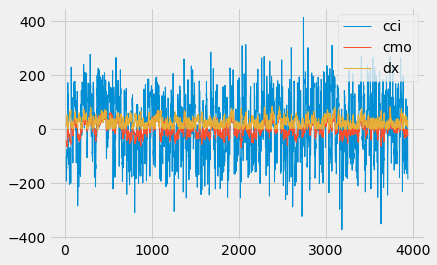

In [14]:
dataset[['cci','cmo','dx']].plot(linewidth=1)

In [15]:
dataset['mfi'] = ta.MFI(dataset.high.to_numpy(), dataset.low.to_numpy(), dataset.close.to_numpy(), dataset.vol.to_numpy(), timeperiod=14)
dataset['minus_di'] = ta.MINUS_DI(dataset.high.to_numpy(), dataset.low.to_numpy(), dataset.close.to_numpy(), timeperiod=14)
dataset['minus_dm'] = ta.MINUS_DM(dataset.high.to_numpy(), dataset.low.to_numpy(), timeperiod=14)
dataset['mom'] = ta.MOM(dataset.close.to_numpy(),timeperiod=10)
dataset

,ts_code,trade_date,pre_close,open,high,low,close,change,pct_chg,vol,...,cci,cmo,dx,macd,macdsignal,macdhist,mfi,minus_di,minus_dm,mom
0,510050.SH,20050223,0.887,0.881,0.882,0.866,0.876,-0.011,-1.2401,12697425.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,510050.SH,20050224,0.876,0.876,0.876,0.868,0.876,0.000,0.0000,4516142.23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,510050.SH,20050225,0.876,0.877,0.887,0.875,0.880,0.004,0.4566,5064606.95,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,510050.SH,20050228,0.880,0.878,0.879,0.870,0.872,-0.008,-0.9091,1879651.93,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,510050.SH,20050301,0.872,0.870,0.873,0.865,0.867,-0.005,-0.5734,2080944.56,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3937,510050.SH,20210429,3.467,3.476,3.515,3.463,3.513,0.046,1.3268,5186873.94,...,84.386021,-0.304388,7.163367,-0.025334,-0.033216,0.007882,31.580666,20.653258,0.164792,0.094
3938,510050.SH,20210430,3.513,3.510,3.517,3.460,3.482,-0.031,-0.8824,7126829.01,...,47.497138,-7.636599,8.128457,-0.023823,-0.031337,0.007515,31.692132,19.553833,0.156021,0.048
3939,510050.SH,20210506,3.482,3.462,3.508,3.432,3.444,-0.038,-1.0913,6658387.28,...,-29.874908,-15.810399,16.819858,-0.025398,-0.030149,0.004751,31.625038,21.162220,0.172876,-0.056
3940,510050.SH,20210507,3.444,3.455,3.460,3.390,3.399,-0.045,-1.3066,4522384.41,...,-141.474910,-24.348393,27.846474,-0.029933,-0.030106,0.000173,32.417098,24.443387,0.202528,-0.093


## 成交量指标

In [16]:
dataset['AD'] = ta.AD(dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy(),dataset.vol.to_numpy())
dataset

,ts_code,trade_date,pre_close,open,high,low,close,change,pct_chg,vol,...,cmo,dx,macd,macdsignal,macdhist,mfi,minus_di,minus_dm,mom,AD
0,510050.SH,20050223,0.887,0.881,0.882,0.866,0.876,-0.011,-1.2401,12697425.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.174356e+06
1,510050.SH,20050224,0.876,0.876,0.876,0.868,0.876,0.000,0.0000,4516142.23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.690499e+06
2,510050.SH,20050225,0.876,0.877,0.887,0.875,0.880,0.004,0.4566,5064606.95,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.846397e+06
3,510050.SH,20050228,0.880,0.878,0.879,0.870,0.872,-0.008,-0.9091,1879651.93,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.802146e+06
4,510050.SH,20050301,0.872,0.870,0.873,0.865,0.867,-0.005,-0.5734,2080944.56,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.761674e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3937,510050.SH,20210429,3.467,3.476,3.515,3.463,3.513,0.046,1.3268,5186873.94,...,-0.304388,7.163367,-0.025334,-0.033216,0.007882,31.580666,20.653258,0.164792,0.094,7.053337e+08
3938,510050.SH,20210430,3.513,3.510,3.517,3.460,3.482,-0.031,-0.8824,7126829.01,...,-7.636599,8.128457,-0.023823,-0.031337,0.007515,31.692132,19.553833,0.156021,0.048,7.037083e+08
3939,510050.SH,20210506,3.482,3.462,3.508,3.432,3.444,-0.038,-1.0913,6658387.28,...,-15.810399,16.819858,-0.025398,-0.030149,0.004751,31.625038,21.162220,0.172876,-0.056,6.991525e+08
3940,510050.SH,20210507,3.444,3.455,3.460,3.390,3.399,-0.045,-1.3066,4522384.41,...,-24.348393,27.846474,-0.029933,-0.030106,0.000173,32.417098,24.443387,0.202528,-0.093,6.957930e+08


In [17]:
dataset['ADOSC'] = ta.ADOSC(dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy(),dataset.vol.to_numpy(),fastperiod=3, slowperiod=10)
dataset

,ts_code,trade_date,pre_close,open,high,low,close,change,pct_chg,vol,...,dx,macd,macdsignal,macdhist,mfi,minus_di,minus_dm,mom,AD,ADOSC
0,510050.SH,20050223,0.887,0.881,0.882,0.866,0.876,-0.011,-1.2401,12697425.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.174356e+06,NaN
1,510050.SH,20050224,0.876,0.876,0.876,0.868,0.876,0.000,0.0000,4516142.23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.690499e+06,NaN
2,510050.SH,20050225,0.876,0.877,0.887,0.875,0.880,0.004,0.4566,5064606.95,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.846397e+06,NaN
3,510050.SH,20050228,0.880,0.878,0.879,0.870,0.872,-0.008,-0.9091,1879651.93,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.802146e+06,NaN
4,510050.SH,20050301,0.872,0.870,0.873,0.865,0.867,-0.005,-0.5734,2080944.56,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.761674e+06,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3937,510050.SH,20210429,3.467,3.476,3.515,3.463,3.513,0.046,1.3268,5186873.94,...,7.163367,-0.025334,-0.033216,0.007882,31.580666,20.653258,0.164792,0.094,7.053337e+08,4.316886e+06
3938,510050.SH,20210430,3.513,3.510,3.517,3.460,3.482,-0.031,-0.8824,7126829.01,...,8.128457,-0.023823,-0.031337,0.007515,31.692132,19.553833,0.156021,0.048,7.037083e+08,4.221448e+06
3939,510050.SH,20210506,3.482,3.462,3.508,3.432,3.444,-0.038,-1.0913,6658387.28,...,16.819858,-0.025398,-0.030149,0.004751,31.625038,21.162220,0.172876,-0.056,6.991525e+08,2.349084e+06
3940,510050.SH,20210507,3.444,3.455,3.460,3.390,3.399,-0.045,-1.3066,4522384.41,...,27.846474,-0.029933,-0.030106,0.000173,32.417098,24.443387,0.202528,-0.093,6.957930e+08,3.006367e+05


In [18]:
dataset['OBV'] = ta.OBV(dataset.close.to_numpy(),dataset.vol.to_numpy())
dataset

,ts_code,trade_date,pre_close,open,high,low,close,change,pct_chg,vol,...,macd,macdsignal,macdhist,mfi,minus_di,minus_dm,mom,AD,ADOSC,OBV
0,510050.SH,20050223,0.887,0.881,0.882,0.866,0.876,-0.011,-1.2401,12697425.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.174356e+06,NaN,1.269743e+07
1,510050.SH,20050224,0.876,0.876,0.876,0.868,0.876,0.000,0.0000,4516142.23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.690499e+06,NaN,1.269743e+07
2,510050.SH,20050225,0.876,0.877,0.887,0.875,0.880,0.004,0.4566,5064606.95,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.846397e+06,NaN,1.776203e+07
3,510050.SH,20050228,0.880,0.878,0.879,0.870,0.872,-0.008,-0.9091,1879651.93,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.802146e+06,NaN,1.588238e+07
4,510050.SH,20050301,0.872,0.870,0.873,0.865,0.867,-0.005,-0.5734,2080944.56,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.761674e+06,NaN,1.380144e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3937,510050.SH,20210429,3.467,3.476,3.515,3.463,3.513,0.046,1.3268,5186873.94,...,-0.025334,-0.033216,0.007882,31.580666,20.653258,0.164792,0.094,7.053337e+08,4.316886e+06,1.021195e+09
3938,510050.SH,20210430,3.513,3.510,3.517,3.460,3.482,-0.031,-0.8824,7126829.01,...,-0.023823,-0.031337,0.007515,31.692132,19.553833,0.156021,0.048,7.037083e+08,4.221448e+06,1.014068e+09
3939,510050.SH,20210506,3.482,3.462,3.508,3.432,3.444,-0.038,-1.0913,6658387.28,...,-0.025398,-0.030149,0.004751,31.625038,21.162220,0.172876,-0.056,6.991525e+08,2.349084e+06,1.007410e+09
3940,510050.SH,20210507,3.444,3.455,3.460,3.390,3.399,-0.045,-1.3066,4522384.41,...,-0.029933,-0.030106,0.000173,32.417098,24.443387,0.202528,-0.093,6.957930e+08,3.006367e+05,1.002888e+09


<AxesSubplot:>

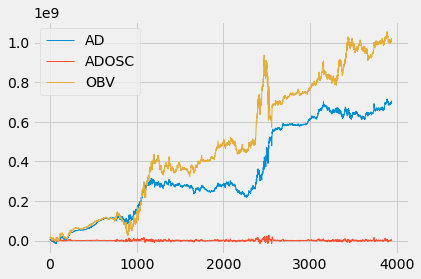

In [19]:
dataset[['AD','ADOSC','OBV']].plot(linewidth=1)

## 波动率指标函数

In [20]:
dataset['natr'] = ta.NATR(dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy(),timeperiod=14)
dataset['atr'] = ta.ATR(dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy(),timeperiod=14)
dataset['TRANGE'] = ta.TRANGE(dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset

,ts_code,trade_date,pre_close,open,high,low,close,change,pct_chg,vol,...,mfi,minus_di,minus_dm,mom,AD,ADOSC,OBV,natr,atr,TRANGE
0,510050.SH,20050223,0.887,0.881,0.882,0.866,0.876,-0.011,-1.2401,12697425.42,...,NaN,NaN,NaN,NaN,3.174356e+06,NaN,1.269743e+07,NaN,NaN,NaN
1,510050.SH,20050224,0.876,0.876,0.876,0.868,0.876,0.000,0.0000,4516142.23,...,NaN,NaN,NaN,NaN,7.690499e+06,NaN,1.269743e+07,NaN,NaN,0.008
2,510050.SH,20050225,0.876,0.877,0.887,0.875,0.880,0.004,0.4566,5064606.95,...,NaN,NaN,NaN,NaN,6.846397e+06,NaN,1.776203e+07,NaN,NaN,0.012
3,510050.SH,20050228,0.880,0.878,0.879,0.870,0.872,-0.008,-0.9091,1879651.93,...,NaN,NaN,NaN,NaN,5.802146e+06,NaN,1.588238e+07,NaN,NaN,0.010
4,510050.SH,20050301,0.872,0.870,0.873,0.865,0.867,-0.005,-0.5734,2080944.56,...,NaN,NaN,NaN,NaN,4.761674e+06,NaN,1.380144e+07,NaN,NaN,0.008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3937,510050.SH,20210429,3.467,3.476,3.515,3.463,3.513,0.046,1.3268,5186873.94,...,31.580666,20.653258,0.164792,0.094,7.053337e+08,4.316886e+06,1.021195e+09,1.622335,0.056993,0.052
3938,510050.SH,20210430,3.513,3.510,3.517,3.460,3.482,-0.031,-0.8824,7126829.01,...,31.692132,19.553833,0.156021,0.048,7.037083e+08,4.221448e+06,1.014068e+09,1.636794,0.056993,0.057
3939,510050.SH,20210506,3.482,3.462,3.508,3.432,3.444,-0.038,-1.0913,6658387.28,...,31.625038,21.162220,0.172876,-0.056,6.991525e+08,2.349084e+06,1.007410e+09,1.694274,0.058351,0.076
3940,510050.SH,20210507,3.444,3.455,3.460,3.390,3.399,-0.045,-1.3066,4522384.41,...,32.417098,24.443387,0.202528,-0.093,6.957930e+08,3.006367e+05,1.002888e+09,1.741185,0.059183,0.070


<AxesSubplot:>

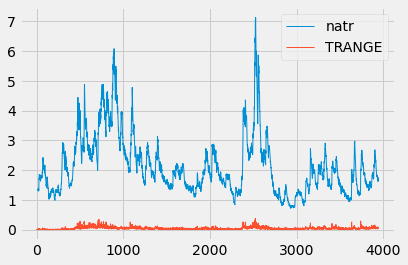

In [21]:
dataset[['natr','TRANGE']].plot(linewidth=1)

## 价格指标

In [22]:
dataset['avgprice'] = ta.AVGPRICE(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['medprice'] = ta.MEDPRICE(dataset.high.to_numpy(),dataset.low.to_numpy())
dataset['typprice'] = ta.TYPPRICE(dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['wclprice'] = ta.WCLPRICE(dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset

,ts_code,trade_date,pre_close,open,high,low,close,change,pct_chg,vol,...,AD,ADOSC,OBV,natr,atr,TRANGE,avgprice,medprice,typprice,wclprice
0,510050.SH,20050223,0.887,0.881,0.882,0.866,0.876,-0.011,-1.2401,12697425.42,...,3.174356e+06,NaN,1.269743e+07,NaN,NaN,NaN,0.87625,0.8740,0.874667,0.87500
1,510050.SH,20050224,0.876,0.876,0.876,0.868,0.876,0.000,0.0000,4516142.23,...,7.690499e+06,NaN,1.269743e+07,NaN,NaN,0.008,0.87400,0.8720,0.873333,0.87400
2,510050.SH,20050225,0.876,0.877,0.887,0.875,0.880,0.004,0.4566,5064606.95,...,6.846397e+06,NaN,1.776203e+07,NaN,NaN,0.012,0.87975,0.8810,0.880667,0.88050
3,510050.SH,20050228,0.880,0.878,0.879,0.870,0.872,-0.008,-0.9091,1879651.93,...,5.802146e+06,NaN,1.588238e+07,NaN,NaN,0.010,0.87475,0.8745,0.873667,0.87325
4,510050.SH,20050301,0.872,0.870,0.873,0.865,0.867,-0.005,-0.5734,2080944.56,...,4.761674e+06,NaN,1.380144e+07,NaN,NaN,0.008,0.86875,0.8690,0.868333,0.86800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3937,510050.SH,20210429,3.467,3.476,3.515,3.463,3.513,0.046,1.3268,5186873.94,...,7.053337e+08,4.316886e+06,1.021195e+09,1.622335,0.056993,0.052,3.49175,3.4890,3.497000,3.50100
3938,510050.SH,20210430,3.513,3.510,3.517,3.460,3.482,-0.031,-0.8824,7126829.01,...,7.037083e+08,4.221448e+06,1.014068e+09,1.636794,0.056993,0.057,3.49225,3.4885,3.486333,3.48525
3939,510050.SH,20210506,3.482,3.462,3.508,3.432,3.444,-0.038,-1.0913,6658387.28,...,6.991525e+08,2.349084e+06,1.007410e+09,1.694274,0.058351,0.076,3.46150,3.4700,3.461333,3.45700
3940,510050.SH,20210507,3.444,3.455,3.460,3.390,3.399,-0.045,-1.3066,4522384.41,...,6.957930e+08,3.006367e+05,1.002888e+09,1.741185,0.059183,0.070,3.42600,3.4250,3.416333,3.41200


<AxesSubplot:>

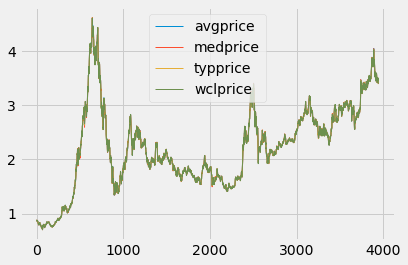

In [23]:
dataset[['avgprice','medprice','typprice','wclprice']].plot(linewidth=1)

## 周期性指标

In [24]:
dataset['ht_dcperiod'] = ta.HT_DCPERIOD(dataset.close.to_numpy())
dataset['ht_dcphase'] = ta.HT_DCPHASE(dataset.close.to_numpy())
inphase,quadrature = ta.HT_PHASOR(dataset.close.to_numpy())
dataset['inphase'] = inphase
dataset['quadrature'] = quadrature
dataset['sine'],dataset['leadsine'] = ta.HT_SINE(dataset.close.to_numpy())
dataset['ht_trendmode'] = ta.HT_TRENDMODE(dataset.close.to_numpy())
dataset

,ts_code,trade_date,pre_close,open,high,low,close,change,pct_chg,vol,...,medprice,typprice,wclprice,ht_dcperiod,ht_dcphase,inphase,quadrature,sine,leadsine,ht_trendmode
0,510050.SH,20050223,0.887,0.881,0.882,0.866,0.876,-0.011,-1.2401,12697425.42,...,0.8740,0.874667,0.87500,NaN,NaN,NaN,NaN,NaN,NaN,0
1,510050.SH,20050224,0.876,0.876,0.876,0.868,0.876,0.000,0.0000,4516142.23,...,0.8720,0.873333,0.87400,NaN,NaN,NaN,NaN,NaN,NaN,0
2,510050.SH,20050225,0.876,0.877,0.887,0.875,0.880,0.004,0.4566,5064606.95,...,0.8810,0.880667,0.88050,NaN,NaN,NaN,NaN,NaN,NaN,0
3,510050.SH,20050228,0.880,0.878,0.879,0.870,0.872,-0.008,-0.9091,1879651.93,...,0.8745,0.873667,0.87325,NaN,NaN,NaN,NaN,NaN,NaN,0
4,510050.SH,20050301,0.872,0.870,0.873,0.865,0.867,-0.005,-0.5734,2080944.56,...,0.8690,0.868333,0.86800,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3937,510050.SH,20210429,3.467,3.476,3.515,3.463,3.513,0.046,1.3268,5186873.94,...,3.4890,3.497000,3.50100,15.270008,143.090770,0.021712,-0.034835,0.600549,-0.140742,0
3938,510050.SH,20210430,3.513,3.510,3.517,3.460,3.482,-0.031,-0.8824,7126829.01,...,3.4885,3.486333,3.48525,15.289011,186.072191,0.010486,-0.038040,-0.105781,-0.777938,0
3939,510050.SH,20210506,3.482,3.462,3.508,3.432,3.444,-0.038,-1.0913,6658387.28,...,3.4700,3.461333,3.45700,15.229222,224.936485,-0.007463,-0.039446,-0.706322,-0.999999,0
3940,510050.SH,20210507,3.444,3.455,3.460,3.390,3.399,-0.045,-1.3066,4522384.41,...,3.4250,3.416333,3.41200,15.139325,258.524485,-0.024330,-0.008356,-0.980010,-0.833650,0


<AxesSubplot:>

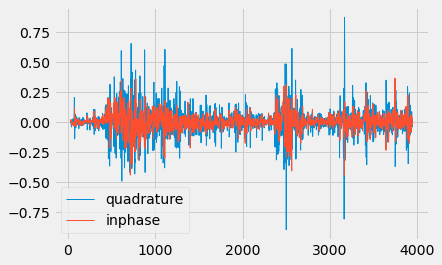

In [25]:
dataset[['quadrature','inphase']].plot(linewidth=1)

## 股市特定规律形态识别

In [26]:
dataset['cdl2crows'] = ta.CDL2CROWS(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdl3blackccrows'] = ta.CDL3BLACKCROWS(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdl3inside'] = ta.CDL3INSIDE(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdl3linestrike'] = ta.CDL3LINESTRIKE(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdl3outside'] = ta.CDL3OUTSIDE(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdl3starsinsouth'] = ta.CDL3STARSINSOUTH(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdl3whitesoldiers'] = ta.CDL3WHITESOLDIERS(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlabandonedbaby'] = ta.CDLABANDONEDBABY(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdladvanceblock'] = ta.CDLADVANCEBLOCK(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlbelthold'] = ta.CDLBELTHOLD(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlbreakaway'] = ta.CDLBREAKAWAY(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlclosingmarubozu'] = ta.CDLCLOSINGMARUBOZU(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlconecalbabyswall'] = ta.CDLCONCEALBABYSWALL(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlcounterattack'] = ta.CDLCOUNTERATTACK(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdldarkcloudcover'] = ta.CDLDARKCLOUDCOVER(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdldoji'] = ta.CDLDOJI(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdldojistar'] = ta.CDLDOJISTAR(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdldragonflydoji'] = ta.CDLDRAGONFLYDOJI(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlengulfing'] = ta.CDLENGULFING(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdleveningdojistar'] = ta.CDLEVENINGDOJISTAR(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy(),penetration=0)
dataset['cdleveningstar'] = ta.CDLEVENINGSTAR(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy(),penetration=0)
dataset['cdlgravestonedoji'] = ta.CDLGRAVESTONEDOJI(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlhammer'] = ta.CDLHAMMER(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlhangingman'] = ta.CDLHANGINGMAN(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlharami'] = ta.CDLHARAMI(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlharamicross'] = ta.CDLHARAMICROSS(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlhighwave'] = ta.CDLHIGHWAVE(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlhikkake'] = ta.CDLHIKKAKE(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlhikkakemod'] = ta.CDLHIKKAKEMOD(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlhomingpigeon'] = ta.CDLHOMINGPIGEON(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlidentical3crows'] = ta.CDLIDENTICAL3CROWS(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlinneck'] = ta.CDLINNECK(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlinvertedhammer'] = ta.CDLINVERTEDHAMMER(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlkicking'] = ta.CDLKICKING(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlkickingbylength'] = ta.CDLKICKINGBYLENGTH(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlladderbottom'] = ta.CDLLADDERBOTTOM(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdllongleggeddoji'] = ta.CDLLONGLEGGEDDOJI(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdllongline'] = ta.CDLLONGLINE(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlmarubozu'] = ta.CDLMARUBOZU(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlmatchinglow'] = ta.CDLMATCHINGLOW(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlmathold'] = ta.CDLMATHOLD(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlmorningdojistar'] = ta.CDLMORNINGDOJISTAR(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlmorningstar'] = ta.CDLMORNINGSTAR(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlonneck'] = ta.CDLONNECK(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlpiercing'] = ta.CDLPIERCING(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlrickshawman'] = ta.CDLRICKSHAWMAN(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlrisefall3methods'] = ta.CDLRISEFALL3METHODS(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlseparatinglines'] = ta.CDLSEPARATINGLINES(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlshootingshar'] = ta.CDLSHOOTINGSTAR(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlshortline'] = ta.CDLSHORTLINE(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlspinningtop'] = ta.CDLSPINNINGTOP(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlstalledpattern'] = ta.CDLSTALLEDPATTERN(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlsticksandwich'] = ta.CDLSTICKSANDWICH(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdltakuri'] = ta.CDLTAKURI(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdltasukigap'] = ta.CDLTASUKIGAP(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlthrusting'] = ta.CDLTHRUSTING(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdltristar'] = ta.CDLTRISTAR(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlunique3river'] = ta.CDLUNIQUE3RIVER(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlupsidegap2crows'] = ta.CDLUPSIDEGAP2CROWS(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlxsidegap3methods'] = ta.CDLXSIDEGAP3METHODS(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())

array([[<AxesSubplot:title={'center':'cdlspinningtop'}>,
        <AxesSubplot:title={'center':'cdlthrusting'}>]], dtype=object)

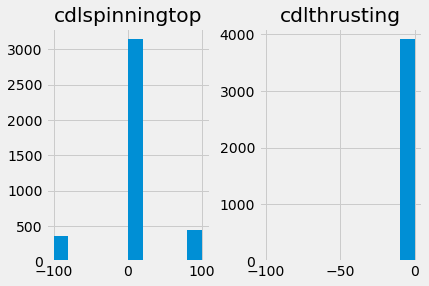

In [27]:
dataset[['cdlspinningtop','cdlthrusting']].hist()

In [28]:
dataset = dataset.dropna(how='any')
dataset

,ts_code,trade_date,pre_close,open,high,low,close,change,pct_chg,vol,...,cdlspinningtop,cdlstalledpattern,cdlsticksandwich,cdltakuri,cdltasukigap,cdlthrusting,cdltristar,cdlunique3river,cdlupsidegap2crows,cdlxsidegap3methods
174,510050.SH,20051108,0.766,0.765,0.774,0.763,0.772,0.006,0.7833,877776.25,...,0,0,0,0,0,0,0,0,0,0
175,510050.SH,20051109,0.772,0.770,0.774,0.765,0.766,-0.006,-0.7772,5398117.36,...,0,0,0,0,0,0,0,0,0,0
176,510050.SH,20051110,0.766,0.764,0.768,0.754,0.755,-0.011,-1.4360,4710164.68,...,0,0,0,0,0,0,0,0,0,0
177,510050.SH,20051111,0.755,0.753,0.759,0.752,0.756,0.001,0.1325,719269.42,...,0,0,0,0,0,-100,0,0,0,0
178,510050.SH,20051114,0.756,0.755,0.757,0.752,0.752,-0.004,-0.5291,553013.59,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3937,510050.SH,20210429,3.467,3.476,3.515,3.463,3.513,0.046,1.3268,5186873.94,...,0,0,0,0,0,0,0,0,0,0
3938,510050.SH,20210430,3.513,3.510,3.517,3.460,3.482,-0.031,-0.8824,7126829.01,...,0,0,0,0,0,0,0,0,0,0
3939,510050.SH,20210506,3.482,3.462,3.508,3.432,3.444,-0.038,-1.0913,6658387.28,...,0,0,0,0,0,0,0,0,0,0
3940,510050.SH,20210507,3.444,3.455,3.460,3.390,3.399,-0.045,-1.3066,4522384.41,...,0,0,0,0,0,0,0,0,0,0


## 预测close收盘价：

### 长\短时间序列预测，根据train_num确定训练集数量，剩余为测试集，以train_num=2000为例：

### 使用LSTM进行预测

In [29]:
features_close = dataset.drop(labels = ['label','ts_code','trade_date'], axis = 1)
label_close = dataset.close

#### 训练/测试集划分与走势图绘制

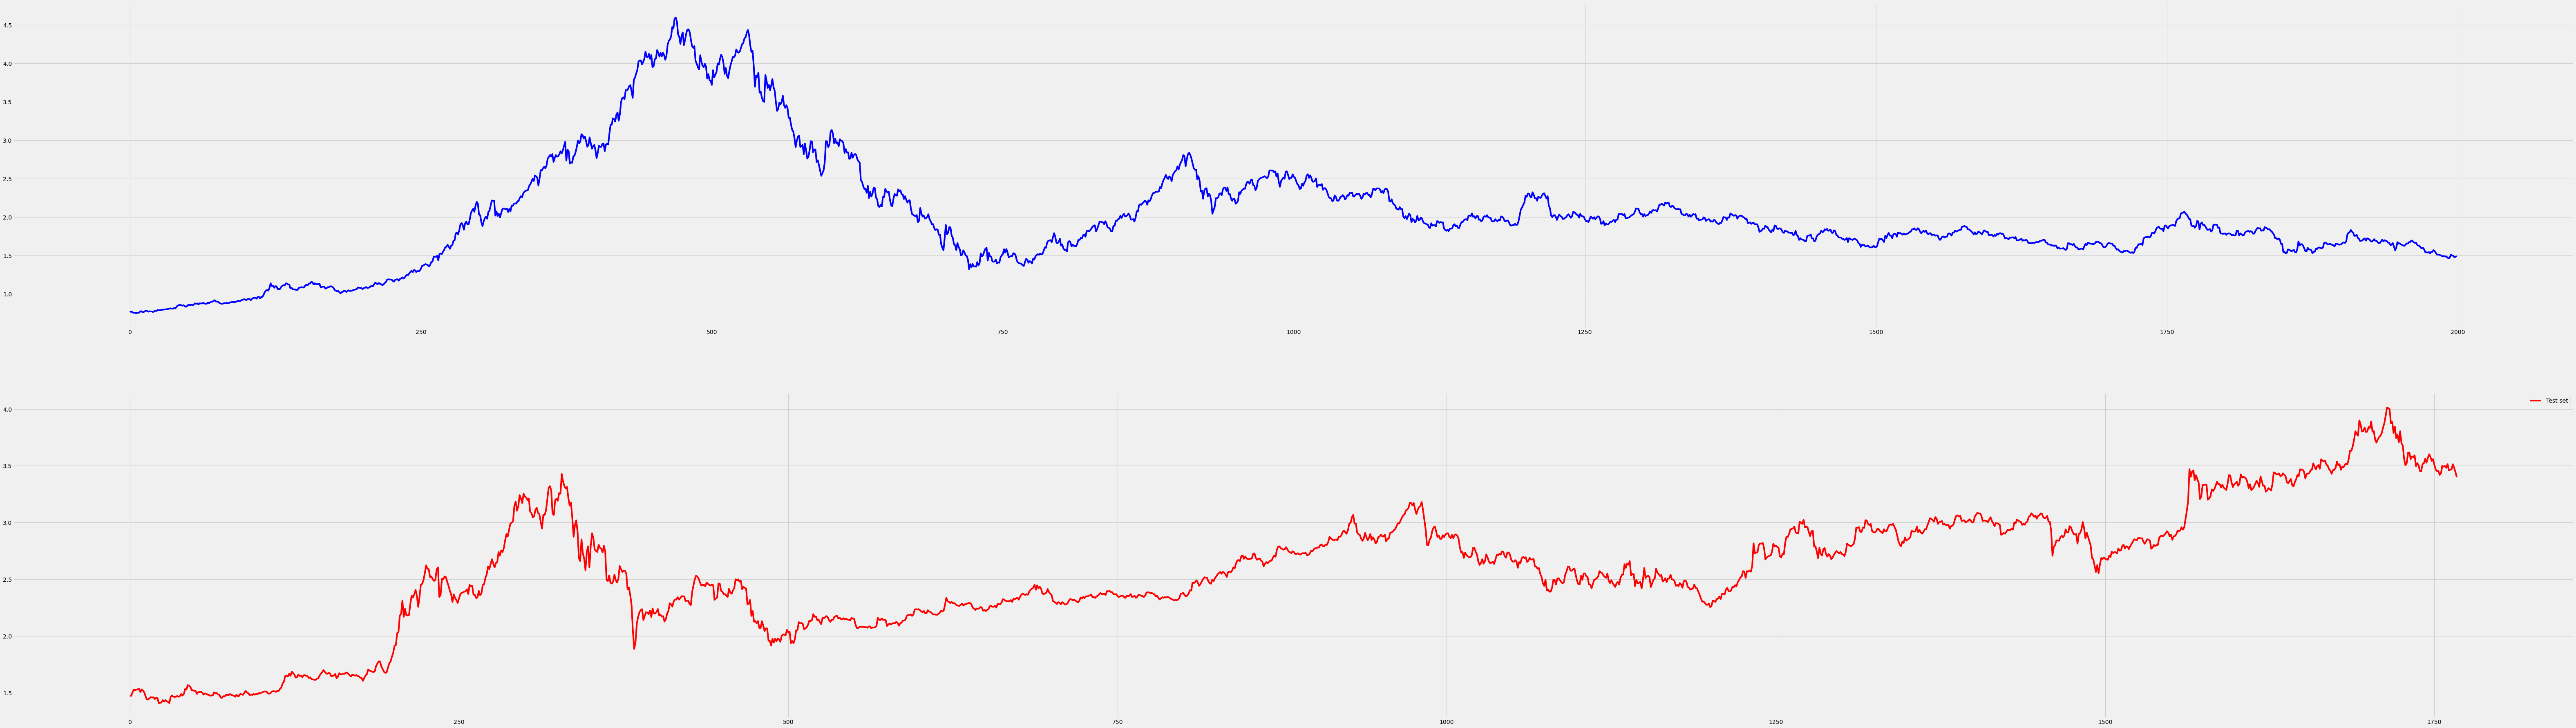

In [30]:
train_num = 2000
training_set = features_close[:train_num].values.astype('float')
test_set = features_close[train_num:].values.astype('float')
train_label = label_close[:train_num].values.astype('float')
test_label = label_close[train_num:].values.astype('float')

fig, (axes1, axes2) = plt.subplots(2, 1, figsize=(100, 30))

axes1.plot(training_set[:,0], color='blue', label='Training set')
axes2.plot(test_set[:,0], color='red', label='Test set')
plt.legend()
plt.show()

In [31]:
# scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

time_step = 5
X_train = []
y_train = []
for i in range(time_step, len(training_set)):
    X_train.append(training_set_scaled[(i-time_step):i,:])
    y_train.append(train_label[i])
X_train, y_train = np.array(X_train), np.array(y_train)


In [32]:
# LSTM
regressor = Sequential()
# firt LSTM layer
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
regressor.add(Dropout(0.2))
# second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# output layer
regressor.add(Dense(units=1))
# compile the RNN
regressor.compile(optimizer='rmsprop', loss='mean_squared_error')
# fit to the training set
regressor.fit(X_train, y_train, epochs=60, batch_size=32)

Train on 1995 samples
Epoch 1/60
1995/1995 [==============================] - 13s 6ms/sample - loss: 0.4668
Epoch 2/60
1995/1995 [==============================] - 1s 511us/sample - loss: 0.1413
Epoch 3/60
1995/1995 [==============================] - 1s 510us/sample - loss: 0.1216
Epoch 4/60
1995/1995 [==============================] - 1s 512us/sample - loss: 0.0969
Epoch 5/60
1995/1995 [==============================] - 1s 512us/sample - loss: 0.0870s - l
Epoch 6/60
1995/1995 [==============================] - 1s 510us/sample - loss: 0.0765
Epoch 7/60
1995/1995 [==============================] - 1s 505us/sample - loss: 0.0757
Epoch 8/60
1995/1995 [==============================] - 1s 504us/sample - loss: 0.0682
Epoch 9/60
1995/1995 [==============================] - 1s 510us/sample - loss: 0.0594
Epoch 10/60
1995/1995 [==============================] - 1s 507us/sample - loss: 0.0628
Epoch 11/60
1995/1995 [==============================] - 1s 507us/sample - loss: 0.0512
Epoch 12/60
199

In [33]:
# scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
test_set_scaled = sc.fit_transform(test_set)
time_step = 5
# create a data structure with 60 timesteps and 1 output, 
# so for each element of training set, there are 60 previous training set elements
X_test = [] # feature
y_test = [] # lable
# training_set length is 7056, it is the total days between 1990-01-01 and 2017-12-29, also is the rows in the csv file
for i in range(time_step, len(test_set)):
    X_test.append(test_set_scaled[(i-time_step):i,:])
    y_test.append(test_label[i])
X_test, y_test = np.array(X_test), np.array(y_test)

In [34]:
#X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],))
LSTM_predicted_stock_price_close = regressor.predict(X_test)
#LSTM_predicted_stock_price = sc.inverse_transform(LSTM_predicted_stock_price)

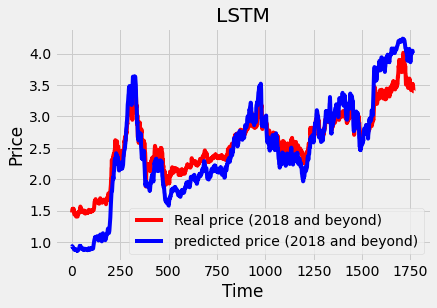

In [35]:
plt.plot(test_label, color='red', label='Real price (2018 and beyond)')
plt.plot(LSTM_predicted_stock_price_close, color='blue', label='predicted price (2018 and beyond)')
plt.title('LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [36]:
label = []
for i in range(len(LSTM_predicted_stock_price_close)):
    if i == 0:
        label.append(1)
    else:
        label.append(int(LSTM_predicted_stock_price_close[i-1]<LSTM_predicted_stock_price_close[i]))

In [37]:
label2 = []
for i in range(len(test_label)):
    if i == 0:
        label2.append(1)
    else:
        label2.append(int(test_label[i-1]<test_label[i]))

In [38]:
sum_ = 0
for i in range(len(label)):
    if label2[i+4] == label[i]:
        sum_+=1
sum_/len(label)

0.6908678389109473

### 使用GRU进行预测

In [39]:
regressorGRU = Sequential()
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(GRU(units=50, return_sequences=True))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(GRU(units=50, return_sequences=True))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(GRU(units=50))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(Dense(units=1))
# compile the RNN
regressorGRU.compile(optimizer='rmsprop', loss='mean_squared_error')
# fit to the training set
regressorGRU.fit(X_train, y_train, epochs=60, batch_size=32)

Train on 1995 samples
Epoch 1/60
1995/1995 [==============================] - 13s 6ms/sample - loss: 0.3250
Epoch 2/60
1995/1995 [==============================] - 1s 505us/sample - loss: 0.1530
Epoch 3/60
1995/1995 [==============================] - 1s 510us/sample - loss: 0.1142
Epoch 4/60
1995/1995 [==============================] - 1s 513us/sample - loss: 0.1062
Epoch 5/60
1995/1995 [==============================] - 1s 514us/sample - loss: 0.0896
Epoch 6/60
1995/1995 [==============================] - 1s 515us/sample - loss: 0.0786
Epoch 7/60
1995/1995 [==============================] - 1s 520us/sample - loss: 0.0733
Epoch 8/60
1995/1995 [==============================] - 1s 504us/sample - loss: 0.0727
Epoch 9/60
1995/1995 [==============================] - 1s 517us/sample - loss: 0.0636
Epoch 10/60
1995/1995 [==============================] - 1s 517us/sample - loss: 0.0615
Epoch 11/60
1995/1995 [==============================] - 1s 501us/sample - loss: 0.0579
Epoch 12/60
1995/199

In [40]:
#X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],))
LSTM_predicted_stock_price_close_GRU = regressorGRU.predict(X_test)
#LSTM_predicted_stock_price = sc.inverse_transform(LSTM_predicted_stock_price)

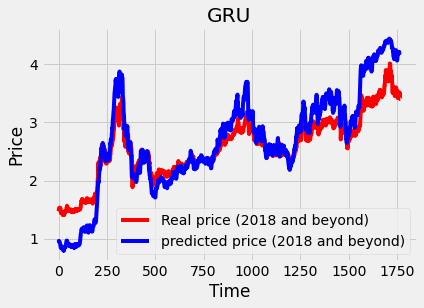

In [41]:
plt.plot(test_label, color='red', label='Real price (2018 and beyond)')
plt.plot(LSTM_predicted_stock_price_close_GRU, color='blue', label='predicted price (2018 and beyond)')
plt.title('GRU')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [42]:
len(test_label),len(LSTM_predicted_stock_price_close_GRU)

(1768, 1763)

In [43]:
test_label[0:5]

array([1.472, 1.501, 1.526, 1.522, 1.527])

In [44]:
LSTM_predicted_stock_price_close_GRU[0:5]

array([[0.9463042 ],
       [0.96239567],
       [0.94959015],
       [0.94492805],
       [0.94987607]], dtype=float32)

In [45]:
label = []
for i in range(len(LSTM_predicted_stock_price_close_GRU)):
    if i == 0:
        label.append(1)
    else:
        label.append(int(LSTM_predicted_stock_price_close_GRU[i-1]<LSTM_predicted_stock_price_close_GRU[i]))
label[0:5]

[1, 1, 0, 0, 1]

In [46]:
label2 = []
for i in range(len(test_label)):
    if i == 0:
        label2.append(1)
    else:
        label2.append(int(test_label[i-1]<test_label[i]))
label2[0:5]

[1, 1, 1, 0, 1]

In [47]:
sum_ = 0
for i in range(len(label)):
    if label2[i+4] == label[i]:
        sum_+=1
sum_/len(label)

0.7101531480431084

### 使用双向LSTM进行预测

In [48]:
# BiLSTM
regressorBiLSTM = Sequential()
# firt LSTM layer
regressorBiLSTM.add(Bidirectional(LSTM(units=50, return_sequences=True), input_shape=(X_train.shape[1],X_train.shape[2]), merge_mode='concat'))
regressorBiLSTM.add(Dropout(0.2))
# second LSTM layer
regressorBiLSTM.add(Bidirectional(LSTM(units=50, return_sequences=True)))
regressorBiLSTM.add(Dropout(0.2))
# third LSTM layer
regressorBiLSTM.add(Bidirectional(LSTM(units=50, return_sequences=True)))
regressorBiLSTM.add(Dropout(0.2))
# fourth LSTM layer
regressorBiLSTM.add(Bidirectional(LSTM(units=50)))
regressorBiLSTM.add(Dropout(0.2))
# output layer
regressorBiLSTM.add(Dense(units=1))
# compile the RNN
regressorBiLSTM.compile(optimizer='rmsprop', loss='mean_squared_error')
# fit to the training set
regressorBiLSTM.fit(X_train, y_train, epochs=60, batch_size=32)

Train on 1995 samples
Epoch 1/60
1995/1995 [==============================] - 23s 11ms/sample - loss: 0.3757
Epoch 2/60
1995/1995 [==============================] - 2s 765us/sample - loss: 0.1179
Epoch 3/60
1995/1995 [==============================] - 2s 762us/sample - loss: 0.0911
Epoch 4/60
1995/1995 [==============================] - 2s 769us/sample - loss: 0.0810
Epoch 5/60
1995/1995 [==============================] - 2s 779us/sample - loss: 0.0678
Epoch 6/60
1995/1995 [==============================] - 2s 754us/sample - loss: 0.0575
Epoch 7/60
1995/1995 [==============================] - 2s 771us/sample - loss: 0.0541
Epoch 8/60
1995/1995 [==============================] - 2s 770us/sample - loss: 0.0502
Epoch 9/60
1995/1995 [==============================] - 2s 775us/sample - loss: 0.0462
Epoch 10/60
1995/1995 [==============================] - 2s 772us/sample - loss: 0.0427
Epoch 11/60
1995/1995 [==============================] - 2s 757us/sample - loss: 0.0422s - loss: 
Epoch 12/

In [49]:
BiLSTM_predicted_stock_price_close = regressorBiLSTM.predict(X_test)

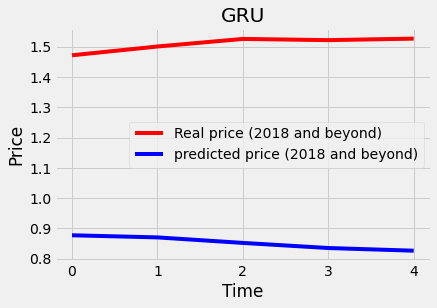

In [50]:
plt.plot(test_label[0:5], color='red', label='Real price (2018 and beyond)')
plt.plot(BiLSTM_predicted_stock_price_close[5:10], color='blue', label='predicted price (2018 and beyond)')
plt.title('GRU')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [51]:
label = []
for i in range(len(BiLSTM_predicted_stock_price_close)):
    label.append(int(BiLSTM_predicted_stock_price_close[i-1]<BiLSTM_predicted_stock_price_close[i]))

In [52]:
label2 = []
for i in range(1,len(test_label)):
    label2.append(int(test_label[i-1]<test_label[i]))

In [53]:
sum_ = 0
for i in range(len(label)):
    if label2[i+3] == label[i]:
        sum_+=1
sum_/len(label)

0.7220646625070902

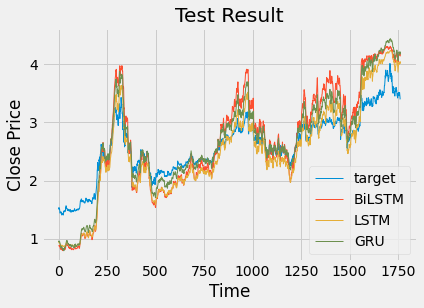

In [54]:
plt.plot(test_label[5:], linewidth=1, label='target')
plt.plot(BiLSTM_predicted_stock_price_close, linewidth=1, label='BiLSTM')
plt.plot(LSTM_predicted_stock_price_close, linewidth=1, label='LSTM')
plt.plot(LSTM_predicted_stock_price_close_GRU,linewidth=1, label='GRU')
plt.title('Test Result')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()